# 3 Preprocessing and Training<a id='3_Preprocessing_and_Training'></a>

 <b>3.1 Introduction <b/>

In this notebook we will build machine learning models and bench mark these models against our average value using different scoring methods such as mean absolute error and mean squared error. We will then examine wether we still need to collect more data and finally select our best model so we could proceed with modeling.

 <b>3.2 Import<b/>

Import relevant python packages

In [26]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

 <b>3.3 Load Data<b/>

Load Combined cycle data set

In [27]:
df = pd.read_excel('combined_cycle.xlsx')

In [28]:
print(df.head())

      AT      V       AP     RH      PE
0  14.96  41.76  1024.07  73.17  463.26
1  25.18  62.96  1020.04  59.08  444.37
2   5.11  39.40  1012.16  92.14  488.56
3  20.86  57.32  1010.24  76.64  446.48
4  10.82  37.50  1009.23  96.62  473.90


 <b>3.4 Train/Test Split<b/>

Subdivide the data set as test and training sets.

In [29]:
len(df) * .7, len(df) * .3

(6697.599999999999, 2870.4)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='PE'), 
                                                    df.PE, test_size=0.3, 
                                                    random_state=10)

30% of data is assigned to the training set

 <b>3.4.1 Examine Training and Test sets<b/>

In [31]:
X_train.shape, X_test.shape

((6697, 4), (2871, 4))

In [32]:
print(X_test)

         AT      V       AP     RH
5925  19.60  48.14  1013.18  68.71
4294  21.28  70.32  1011.55  88.05
7120  28.62  59.14  1016.36  53.10
6688  11.02  40.00  1015.75  74.83
7322  23.02  63.47  1012.21  80.61
...     ...    ...      ...    ...
6996  18.18  67.71  1004.50  87.26
3484  18.68  46.00  1002.20  97.17
8097  13.16  43.71  1024.44  85.68
8513  27.17  67.45  1015.67  49.03
5499  28.87  57.19  1008.09  64.29

[2871 rows x 4 columns]


In [33]:
print(X_test)

         AT      V       AP     RH
5925  19.60  48.14  1013.18  68.71
4294  21.28  70.32  1011.55  88.05
7120  28.62  59.14  1016.36  53.10
6688  11.02  40.00  1015.75  74.83
7322  23.02  63.47  1012.21  80.61
...     ...    ...      ...    ...
6996  18.18  67.71  1004.50  87.26
3484  18.68  46.00  1002.20  97.17
8097  13.16  43.71  1024.44  85.68
8513  27.17  67.45  1015.67  49.03
5499  28.87  57.19  1008.09  64.29

[2871 rows x 4 columns]


<b>3.5 Initial Model - Mean Predictor Model<b/>

Create initial model that will be used to assess the performance of minimum

In [34]:
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train,y_train)


DummyRegressor()

In [35]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([454.27402867, 454.27402867, 454.27402867, 454.27402867,
       454.27402867])

Since our Mean Predictor Model predicts the mean of the data set,predicting the target feature using the training data set produced the mean of training set. 

In [36]:
y_te_pred = dumb_reg.predict(X_test)

In [37]:
y_tr_pred[:5]

array([454.27402867, 454.27402867, 454.27402867, 454.27402867,
       454.27402867])

The Mean Predictor Model predicted the mean of the data training set using the test set as expected.

<b>3.6 Metrics<b/>

<b>3.6.1 R-squared, or coefficient of determination<b/>

The R-squared measures the proportion of variance in the dependent variable model that is predicted by our model.

In [38]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -0.00031021886927429243)

<b>3.6.2 Mean Abosolute Error<b/>

In [39]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(14.775990550149276, 14.95182564212665)

The mean absolute error is the average of the absolute errors:

In [40]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(289.03822692347245, 296.4430974433076)

The mean squared error is the average of the sqaure of the errors:

<b>3.7 Linear Regression Model<b/>

<b>3.7.1 Linear Regression Pipeline<b/>

Create linear regression pipeline that will scale the features, train a model, select the k best features and calculate model performance.

In [41]:
pipe = make_pipeline(
    SelectKBest(f_regression,k='all'), 
    StandardScaler(), 
    LinearRegression()
   
)

Check pipeline parameters

In [42]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'selectkbest', 'standardscaler', 'linearregression', 'selectkbest__k', 'selectkbest__score_func', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize'])

<b>3.7.2 Linear Regression Model Hyperparemeter tuning using GridSearchCV<b/>

Define grid_params

In [43]:
k = [k+1 for k in range(len(X_train.columns))]

grid_params = {'selectkbest__k': k}
print(k)

[1, 2, 3, 4]


Define GridSearchCV for the linear regression model

In [44]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

Fit model

In [45]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(k='all',
                                                    score_func=<function f_regression at 0x0000022507609280>)),
                                       ('standardscaler', StandardScaler()),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1, param_grid={'selectkbest__k': [1, 2, 3, 4]})

Get test scores

In [46]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]


Plot mean_cv score vs k number of features

4


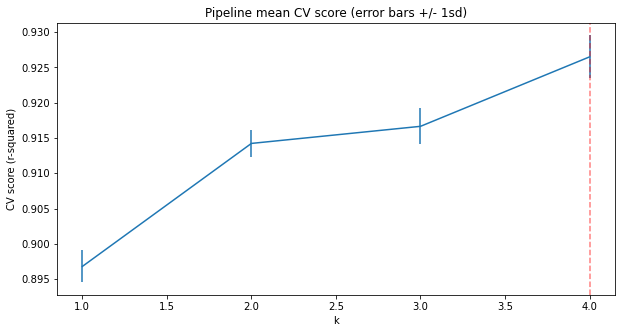

In [79]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');
print(best_k)

Including all 4 features produced the linear regression model with the highest cross-validation sccore.

Find the logical mask of the features selected.

In [49]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [50]:
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

AP     0.409682
RH    -2.221464
V     -3.031877
AT   -14.553435
dtype: float64

As can be see seen increasing the ambient temperature decreases the electrical energy output the most compared to the other three features.

<b>3.8 Random Forest Model<b/>

<b>3.8.1 Random Forest Model Pipeline<b/>

Create Random Forest pipeline that will scale the features, train a model and calculate model performance.

In [80]:
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=10)
)

<b>3.8.2 Random Forest Model Hyperparemeter tuning using GridSearchCV<b/>

In [53]:
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [54]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.95740334, 0.95565328, 0.95308445, 0.9581777 , 0.95483468])

In [55]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.955830690577321, 0.0018191769297832426)

In [56]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None]      
}
print(n_est)
grid_params

[10, 12, 16, 20, 26, 33, 42, 54, 69, 88, 112, 143, 183, 233, 297, 379, 483, 615, 784, 1000]


{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None]}

Define GridSearchCV for the linear regression model

In [57]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [58]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=10))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'standardscaler': [StandardScaler(), None]})

In [59]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 1000,
 'standardscaler': StandardScaler()}

In [60]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.95772238, 0.95629208, 0.95328539, 0.95890624, 0.95503235])

In [61]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.9562476875678882, 0.001974680534877313)

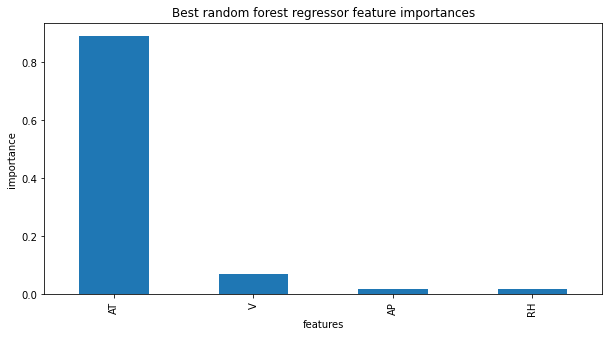

In [62]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');


Just like in the case of the Linear Regression the ambient temperature is the most important feature. 

<b>3.9 Final Model Selection<b/>

<b>3.9.1 Linear Regression Model Performance<b/>

Below is the performance of the best linear regression model.

In [64]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [65]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(3.6477442658655526, 0.03860445158092444)

In [66]:
mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))

3.587931823157423

<b>3.9.2 Random Forest Model Performance<b/>

Below is the performance of the best Random Forest model.

In [68]:
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [69]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(2.531033130591949, 0.047710172635825554)

In [70]:
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

2.3547541100661538

The best Random Forest model is a better model than the best Linear Regression Model

<b>3.10 Data quantity assessment<b/>

In [72]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

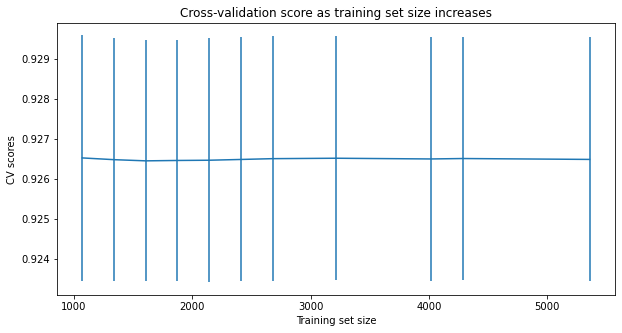

In [73]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

There is no need to collect more data since the CV scores did not increase with increasing data set size.

In [75]:
best_model = rf_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()
    
modelpath = '../models'
if not os.path.exists(modelpath):
    os.mkdir(modelpath)
skimodel_path = os.path.join(modelpath, 'combined_cycle_model.pkl')
if not os.path.exists(skimodel_path):
    with open(skimodel_path, 'wb') as f:
        pickle.dump(best_model, f)

Saving best model object from pipeline

In [77]:
os.getcwd()

'C:\\Users\\ferna\\Dropbox\\Springboard data science bootcamp\\Capstone 2'

<b>Summary<b/>

The model with the highest crossvalidation score and lowest mean absolute error is our best Random Forest Model. As we saw from our models, atmospheric temperature is the best feature when it comes to predicting the electrical energy output. Compared to the dummy regressor model(Mean) our random forest model performed significantly better. The mean absolute error of our best RF is approximately 2 and approximately 15 for the dummy regressor. There is also no need to collect more data because it will not increase the cross-validation score.